In [1]:
import pypsa
import pandas as pd
import numpy as np
import os
import pypsatopo

In [2]:
solver = "cbc"

In [122]:
# Create empty PyPSA network
n = pypsa.Network()

In [292]:
# Set snapshots to the year 2023 and at hourly resolution
snapshots = pd.date_range("01-01-2019", "01-01-2020", freq="h", inclusive="left")
n.set_snapshots(snapshots)

In [294]:
# To calculate annualized capital expenditure
def calculate_annualised_capex(capex: float, interest: float, lifetime: int):
    crf = (
        interest * (1 + interest) ** lifetime / ((1 + interest) ** lifetime - 1)
    )  # Capital recovery factor
    return capex * crf

In [296]:
#Removal of certain components

#n.remove(class_name="Link", name="electricity_flow")
#n.remove(class_name="Bus", name="electricity_storage")

<Axes: xlabel='snapshot'>

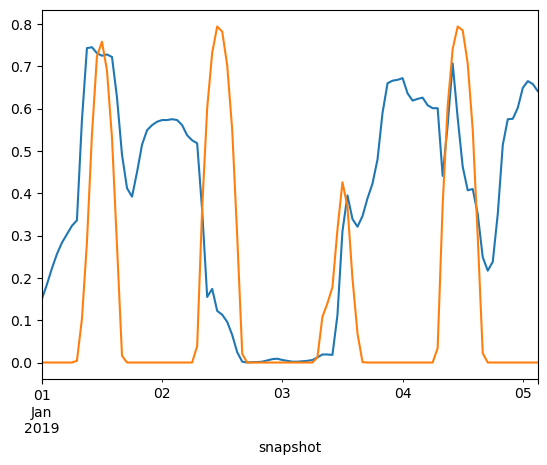

In [298]:
# Import an example of wind daily pattern
wind_pattern = pd.read_csv("/Users/philip/Desktop/AGORA/China PyPSA LCOX/ code/data/LiNi_Chaoyang_wind_41.6807_120.7899_2.csv")["daily pattern"]
# annual time-series availability of onshore wind (just a simplified example)
wind_profile = pd.Series(list(wind_pattern), index=n.snapshots)

# Import an example of solar daily pattern
solar_pattern = pd.read_csv("/Users/philip/Desktop/AGORA/China PyPSA LCOX/ code/data/LiNi_Chaoyang_pv_41.6807_120.7899.csv")["daily pattern"]
# annual time-series availability of solar (just a simplified example)
solar_profile = pd.Series(list(solar_pattern), index=n.snapshots)

# Import an example of wind daily pattern
#load_pattern = pd.read_csv("/Users/philip/Downloads/2024-10-PyPSA-H2-Training/data/weather data/example_industrial_h2_demand_daily_pattern.csv")["daily pattern"]
# annual time-series availability of onshore wind (just a simplified example)
#load_profile = pd.Series(list(load_pattern)*365, index=n.snapshots)

# Print first few values to verify
wind_profile.head(100).plot()
solar_profile.head(100).plot()

In [300]:
# create the buses needed for the methanol system
n.add(class_name="Bus", name="electricity", carrier="electricity", overwrite=True)

#n.add(class_name="Bus", name="electricity_storage", carrier="electricity", overwrite=True)

# hydrogen buses
n.add(class_name="Bus", name="hydrogen", carrier="hydrogen", overwrite=True)
n.add(class_name="Bus", name="hydrogen_storage", carrier="hydrogen", overwrite=True)
# methanol buses
n.add(class_name="Bus", name="methanol", carrier="methanol", overwrite=True)
n.add(class_name="Bus", name="methanol_storage", carrier="methanol", overwrite=True)

n.buses

,v_nom,type,x,y,carrier,unit,v_mag_pu_set,v_mag_pu_min,v_mag_pu_max,control,generator,sub_network
Bus,,,,,,,,,,,,
electricity,1.0,,0.0,0.0,electricity,,1.0,0.0,inf,PQ,,
hydrogen,1.0,,0.0,0.0,hydrogen,,1.0,0.0,inf,PQ,,
hydrogen_storage,1.0,,0.0,0.0,hydrogen,,1.0,0.0,inf,PQ,,
methanol,1.0,,0.0,0.0,methanol,,1.0,0.0,inf,PQ,,
methanol_storage,1.0,,0.0,0.0,methanol,,1.0,0.0,inf,PQ,,


In [302]:
#create the end demand load for methanol

#n.remove(class_name="Load", name="hydrogen_load")
n.add(class_name="Load", name="methanol_load", bus="methanol", p_set=100, overwrite=True) 
#n.add(class_name="Load", name="hydrogen_load", bus="hydrogen", p_set=100, carrier="hydrogen", type="hydrogen_load", overwrite=True)
# or p_set=load_profile
n.loads


,bus,carrier,type,p_set,q_set,sign,active
Load,,,,,,,
methanol_load,methanol,,,100.0,0.0,-1.0,True


In [304]:
#exchange rates
eur_to_usd = 1.1
usd_to_cny = 7.0774

# interest rate / discount rate
interest = 0.0563 # according to BOA PTX; original value: 0.05

In [306]:
# create the generators for wind, based on techno-economic parameters
# Onshore Wind's techno-economic parameters are given as:
lifetime = 20
interest = 0.0563 # according to BOA PTX; original value: 0.05
CAPEX = 4500 * 1000 / usd_to_cny # $/MW
FOM = 2 #% of CAPEX
VOM = 0 # $/MWh variable
efficiency = 1

annualized_capex = calculate_annualised_capex(CAPEX, interest, lifetime)

n.add(
    class_name="Generator", 
    name="onshore_wind",
    bus="electricity",
    carrier="wind",
    p_nom_extendable=True,
    p_nom_min=100, # MW
    #p_nom_max=500, # MW
    capital_cost=annualized_capex + FOM/100 * annualized_capex, #$/MW
    marginal_cost=VOM, #$/MWh
    efficiency=efficiency,
    lifetime=lifetime,
    p_max_pu=wind_profile, 
    overwrite=True
)

Index(['onshore_wind'], dtype='object', name='Generator')

In [308]:
# create the generator for solar, based on techno-economic parameters
# Solar's techno-economic parameters are given as:
lifetime = 25
interest = 0.0563 # according to BOA PTX; original value: 0.05
CAPEX = 3940 * 1000 / usd_to_cny # $/MW
FOM = 1 #% of CAPEX
VOM = 0 # $/MWh variable
efficiency = 1

annualized_capex = calculate_annualised_capex(CAPEX, interest, lifetime)

n.add(
    class_name="Generator", 
    name="solar",
    bus="electricity",
    carrier="solar",
    p_nom_extendable=True,
    p_nom_min=50,
    #p_nom_max=500, # MW
    capital_cost=annualized_capex + FOM/100 * annualized_capex, #$/MW
    marginal_cost=VOM, #$/MWh
    efficiency=efficiency,
    lifetime=lifetime,
    p_max_pu=solar_profile, 
    overwrite=True
)

Index(['solar'], dtype='object', name='Generator')

In [310]:
#create the generator for hybrid supply

#n.add(class_name="Generator", name="hybrid_wind_solar", bus="electricity", carrier="wind", overwrite=True)

n.generators

,bus,control,type,p_nom,p_nom_mod,p_nom_extendable,p_nom_min,p_nom_max,p_min_pu,p_max_pu,...,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,weight,p_nom_opt
Generator,,,,,,,,,,,,,,,,,,,,,
onshore_wind,electricity,PQ,,0.0,0.0,True,100.0,inf,0.0,1.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
solar,electricity,PQ,,0.0,0.0,True,50.0,inf,0.0,1.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0


In [311]:
# create hydrogen storage tank

#Techno-economic data for hydrogen storage tank
lifetime = 20
interest = 0.0563 # according to BOA PTX; original value: 0.05
CAPEX = 59.7 * 1000 # $/MWh (based on H2 compressed storage tank DTU data); original value: 4779.9527
FOM = 0.43 #%/year; unchanged

annualized_capex = calculate_annualised_capex(CAPEX, interest, lifetime)

n.add(
      class_name="Store",
      name="hydrogen_tank",
      type="hydrogen_tank",
      bus="hydrogen_storage",
      carrier="hydrogen",
      capital_cost=annualized_capex + FOM/100 * annualized_capex,
      e_nom_extendable=True,
      e_cyclic=True,
      marginal_cost=1,#$/MWh 
      overwrite=True
)


Index(['hydrogen_tank'], dtype='object')

In [312]:
# create methanol storage tank

# Methanol tank's techno-economic parameters are given as:
eur_to_usd = 1.1
lifetime = 20
interest = 0.0563

CAPEX = 166.8201 * eur_to_usd # $/MWh
FOM = 4.0 # %/year

annualized_capex = calculate_annualised_capex(CAPEX, interest, lifetime)


n.add(
    class_name="Store", 
    name="methanol_tank",
    type="methanol_tank",
    bus="methanol_storage", 
    carrier="methanol",
    e_nom_extendable=True,
#    e_nom_max=5000,
    e_cyclic=False,
#    e_initial=0,
    capital_cost= annualized_capex * FOM/100 * annualized_capex,
    marginal_cost=1, 
    overwrite=True
)

n.stores

,bus,type,carrier,e_nom,e_nom_mod,e_nom_extendable,e_nom_min,e_nom_max,e_min_pu,e_max_pu,...,sign,marginal_cost,marginal_cost_quadratic,marginal_cost_storage,capital_cost,standing_loss,active,build_year,lifetime,e_nom_opt
Store,,,,,,,,,,,,,,,,,,,,,
hydrogen_tank,hydrogen_storage,hydrogen_tank,hydrogen,0.0,0.0,True,0.0,inf,0.0,1.0,...,1.0,1.0,0.0,0.0,5071.388888,0.0,True,0,inf,0.0
methanol_tank,methanol_storage,methanol_tank,methanol,0.0,0.0,True,0.0,inf,0.0,1.0,...,1.0,1.0,0.0,0.0,9.636523,0.0,True,0,inf,0.0


In [313]:
# Techno-economic parameters of a lithium ion battery storage:

lifetime = 12.5  # years (average: 10-15); https://greencubes.com/in-the-news/why-lithium-is-taking-over-stationary-energy-storage/
interest = 0.0563  # unit: -
CAPEX = 160 * 1000  # $/MW; original: 600 # 80USD / kWh storage (Nov 2024), assuming 2Ah storages. Source: https://www.energy-storage.news/mind-blowing-bids-power-chinas-16gwh-bess-tender-state-owned-firms-market-share/
FOM = 1.5  # $/MW per year (between 1% and 2% of the CAPEX)
VOM = 0  # $/MWh
fuel_cost = 0  # $/MWh_th per unit water consumed
efficiency_store = 0.965  # assuming similar storing and discharging efficiencies #https://blog.discoverbattery.com/understanding-charging
efficiency_dispatch = 0.965  # assuming similar storing and discharging efficiencies

annualized_capex = calculate_annualised_capex(CAPEX, interest, lifetime)

n.add(
    class_name="StorageUnit",
    name="battery",
    bus="electricity",
    marginal_cost= VOM + fuel_cost,
    capital_cost=annualized_capex + FOM/100 * annualized_capex,
    p_nom_extendable=True,
    efficiency_store=efficiency_store,
    efficiency_dispatch=efficiency_dispatch,
    p_max_pu=1,  # Discharging availability
    p_min_pu=-1,  # Charging availability
    max_hours=2,  # energy-to-power ratio assumption is 2Ah
#    state_of_charge_initial=100,
    overwrite=True
)


#LCOH MAP is behaving in the same way because hydrogen and ammonia storage are cheaper
# set p_min if you want to really use batteries.

Index(['battery'], dtype='object')

In [314]:
#create the links for electrolysers, methanol synthesis, electricity flow and hydrogen flow
"""
n.add(
    class_name="Link", 
    name="electricity_flow",
    bus0="electricity",
    bus1="electricity_storage",
    p_nom_extendable=True, # allow flexible capacity expansion
    marginal_cost=1, #$/MWh 
    efficiency=1,
    p_min_pu=-1, #bi-directional flow
    overwrite=True
)
"""
n.add(
    class_name="Link", 
    name="hydrogen_flow",
    bus0="hydrogen",
    bus1="hydrogen_storage",
    p_nom_extendable=True, # allow flexible capacity expansion
    marginal_cost=1, #$/MWh 
    efficiency=1,
    p_min_pu=-1, #bi-directional flow
    overwrite=True
)

n.add(
    class_name="Link", 
    name="methanol_flow",
    bus0="methanol",
    bus1="methanol_storage",
    p_nom_extendable=True, # allow flexible capacity expansion
    marginal_cost=1, #$/MWh 
    efficiency=1,
    p_min_pu=-1, #bi-directional flow
    overwrite=True
)

n.links

,bus0,bus1,type,carrier,efficiency,active,build_year,lifetime,p_nom,p_nom_mod,...,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,p_nom_opt,bus2,efficiency2
Link,,,,,,,,,,,,,,,,,,,,,
electrolyser,electricity,hydrogen,,Electrolyser,0.59,True,0,20.0,0.0,0.0,...,0,1,0,0.30,0.300,0.150,1.0,483.720330,,1.00
methanol_synthesis,electricity,methanol,,methanol_synthesis,25.00,True,0,20.0,0.0,0.0,...,0,1,0,0.04,0.004,0.015,1.0,5.218043,hydrogen,-31.25
hydrogen_flow,hydrogen,hydrogen_storage,,,1.00,True,0,inf,0.0,0.0,...,0,1,0,NaN,NaN,1.000,1.0,0.000000,,1.00
methanol_flow,methanol,methanol_storage,,,1.00,True,0,inf,0.0,0.0,...,0,1,0,NaN,NaN,1.000,1.0,0.000000,,1.00


In [320]:
#create the link for the electrolyser

# Electrolyser's techno-economic parameters are given as:
lifetime = 20
interest = 0.05
#water_cost = 1.8 # EUR/m3_H2O --> this includes the water treatment costs applied to the seawater
#water_demand_ratio= 21 # kgH2O/kgH2 --> how much water is needed to produce 1 kg of hydrogen?

CAPEX = 600.34 # $/MW
FOM = 2 # %/year or CAPEX
VOM = 0 # $/MWh variable
efficiency = 0.59
ramp_limit_up= 0.3 #MW/hour Source #4: Bodke et al (2021)
ramp_limit_down = 0.3 #MW/hour Source #4: Bodke et al (2021)
ramp_limit_start_up = 0.15 #MW/hour Source #4: Bodke et al (2021)
min_up_time = 2 #hours Source #4: Bodke et al (2021)

"""
# Calculate marginal cost for water consumption
# marginal cost [USD/MWh] = 
# water_cost [EUR/m3_H2O] * eur_to_usd [USD/EUR] / 1000 [kgH2O/m3_H2O] * water_demand_ratio [kgH2O/kgH2] / (33.33/1000 [MWh/kgH2])
water_cost = ((water_cost * eur_to_usd / 1000) * water_demand_ratio) / (33.33 / 1000) # 1 kgH2 = 33.33 kWh = 0.03333 MWh

# Add a compressor to pressurize hydrogen produced by the electrolyser and feed it to the hydrogen storage
# 1. Calculate the specific electricity consumption for compressor in kWh_el/kWh_H2. Assumption: 0.6 [kWh_el/kgH2]
# 2. Calculate the specific energy consumption for the electrolyser in kWh_el/kWh_H2. This corresponds to the reciprocal of the electrolyser's efficiency.
# 3. The sum of the two specific energy consumptions represents the total specific energy consumption for the electrolyser including compressor.
# 4. Calculate the new efficiency of the electrolyser which is the reciprocal of the total specific energy consumption.
specific_consumption_compressor = 0.6 / 33.33  # 0.6 [kWh_el/kgH2] / 33.33 [kWh_H2/kgH2] --> kWh_el/kWh_H2
specific_consumption_electrolyser = 1 / efficiency # unit: kWh_el/kWh_H2
new_efficiency = 1 / (specific_consumption_compressor + specific_consumption_electrolyser)

# Compressor's techno-economic parameters are given as:
lifetime_com = 25
CAPEX_COM = 1720 * eur_to_usd # $/MW
FOM_COM = 34 * eur_to_usd  # $/MW fixed
VOM_COM = 0 # $/MWh variable
"""
annualized_capex = calculate_annualised_capex(CAPEX, interest, lifetime)
#annualized_capex_com = calculate_annualised_capex(CAPEX_COM, interest, lifetime_com)

n.add(
    class_name="Link",
    name="electrolyser",
    carrier="Electrolyser",
    bus0="electricity",
    bus1="hydrogen",
    p_nom_extendable=True,
    p_nom_min=20,
    capital_cost=annualized_capex + FOM/100 * annualized_capex, #$/MW
    marginal_cost=VOM, #$/MWh
    efficiency=efficiency,
    lifetime=lifetime,
    ramp_limit_up=ramp_limit_up,
    ramp_limit_down=ramp_limit_down,
    ramp_limit_start_up=ramp_limit_start_up,
    min_up_time=min_up_time,
    overwrite=True
)

"""
p_min_pu=0.6 
p_max_pu=1
"""

'\np_min_pu=0.6 \np_max_pu=1\n'

In [321]:
#create the link for the methanol synthesis

# methanol synthesis techno-economic parameters are given as:

lifetime = 20 # original value: 30
interest = 0.0563 # according to BOA PTX; original value: 0.05 

CAPEX = 1339.6 * 1000 # $/MW; original value: XXXX
FOM = 2.0 # %/year 
VOM = 7.460  # $/MWh_MeOh ($ / t CO2 from coal power CCS cost); original value: XXXX
electricity_input_ms = 0.040 #MWh_el/MWh_MeOH (0.142); original value: XXXX
hydrogen_input = 1.250 #MWh_H2/MWh_MeOh (includes efficiency losses); original value: 1.1484
ramp_limit_up= 0.04 #MW/hour Source #4: Bodke et al (2021)
ramp_limit_down = 0.004  #MW/hour amended to same as ramp_limit_up Source #4: Bodke et al (2021) 
ramp_limit_start_up = 0.015 #MW/hour Source #4: Bodke et al (2021)
min_up_time = 2 #hours Source #4: Bodke et al (2021)


annualized_capex = calculate_annualised_capex(CAPEX, interest, lifetime)


n.add(
    class_name = "Link",
    name = "methanol_synthesis",
    bus0="electricity",
    bus1="methanol",
    bus2="hydrogen",
    p_nom_extendable=True,
    carrier="methanol_synthesis",
    efficiency=1 / electricity_input_ms,
    efficiency2=-hydrogen_input / electricity_input_ms,
    capital_cost=(annualized_capex + FOM/100 * annualized_capex) / electricity_input_ms,
    marginal_cost=VOM / electricity_input_ms,
    lifetime=lifetime,
    ramp_limit_up=ramp_limit_up,
    ramp_limit_down=ramp_limit_down,
    ramp_limit_start_up=ramp_limit_start_up,
    min_up_time=min_up_time,
    overwrite=True
)

    

Index(['methanol_synthesis'], dtype='object')

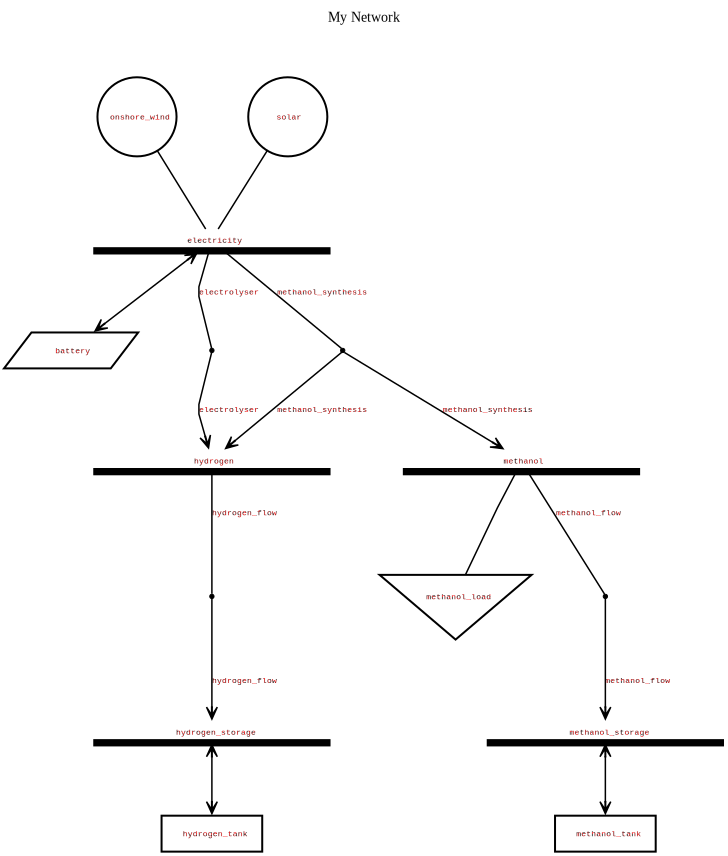

0

In [322]:
pypsatopo.generate(n)

# two outputs 
# Syngas CO + H2 + CO2 
# CO2 as an output 

In [323]:
# Solve network using cbc solver
n.optimize(pyomo=False, solver_name=solver)

Index(['hydrogen_flow', 'methanol_flow', 'electrolyser', 'methanol_synthesis'], dtype='object', name='Link')
Index(['onshore_wind', 'solar'], dtype='object', name='Generator')
Index(['hydrogen_tank', 'methanol_tank'], dtype='object', name='Store')
Index(['electricity', 'hydrogen', 'hydrogen_storage', 'methanol',
       'methanol_storage'],
      dtype='object', name='Bus')
Index(['hydrogen_flow', 'methanol_flow', 'electrolyser', 'methanol_synthesis'], dtype='object', name='Link')
Index(['onshore_wind', 'solar'], dtype='object', name='Generator')
Index(['hydrogen_tank', 'methanol_tank'], dtype='object', name='Store')
Index(['electricity', 'hydrogen', 'hydrogen_storage', 'methanol',
       'methanol_storage'],
      dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Cbc solver
INFO:linopy.model:Solver options:
 - pyomo: False
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|████████████| 11/11 [00:00<00:00, 25.29it/s]
INFO:linopy.io: Writing time: 4.0

('ok', 'optimal')

In [327]:
n.stores_t.p

Store,hydrogen_tank,methanol_tank
snapshot,,
2019-01-01 00:00:00,113.897900,-25.345577
2019-01-01 01:00:00,102.843570,-24.806882
2019-01-01 02:00:00,90.569460,-24.268187
2019-01-01 03:00:00,79.515139,-23.729492
2019-01-01 04:00:00,70.595456,-23.190798
...,...,...
2019-12-31 19:00:00,-6.882656,7.952838
2019-12-31 20:00:00,0.054967,8.491532
2019-12-31 21:00:00,5.162902,9.030227


In [328]:
pd.concat([n.stores_t.e,n.stores_t.p],axis=1).head()


Store,hydrogen_tank,methanol_tank,hydrogen_tank,methanol_tank
snapshot,,,,
2019-01-01 00:00:00,1577.5922,25.345577,113.897900,-25.345577
2019-01-01 01:00:00,1474.7486,50.152459,102.843570,-24.806882
2019-01-01 02:00:00,1384.1791,74.420647,90.569460,-24.268187
2019-01-01 03:00:00,1304.6640,98.150139,79.515139,-23.729492
2019-01-01 04:00:00,1234.0685,121.340940,70.595456,-23.190798


In [329]:
n.generators.p_nom_opt

Generator
onshore_wind    516.86138
solar           244.37337
Name: p_nom_opt, dtype: float64

<Axes: xlabel='snapshot'>

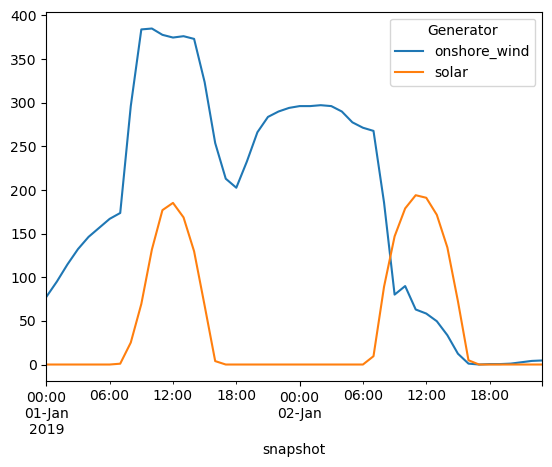

In [330]:
# Inspect the interaction of different power plants to supply loads
n.generators_t.p[:24*2].plot()

<Axes: xlabel='snapshot'>

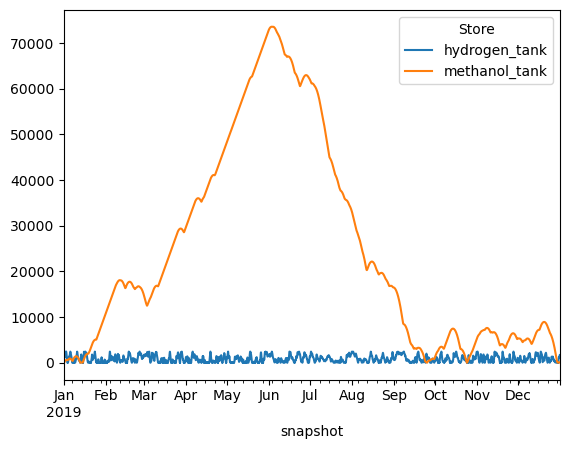

In [331]:
# Inspect the change of energy capacity [MWh] in hydrogen_tank store to supply loads
n.stores_t.e[:24*365].plot()

<Axes: xlabel='snapshot'>

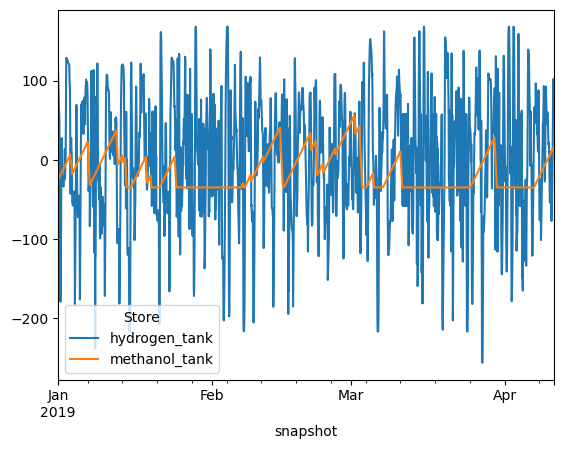

In [332]:
# Inspect the change of power [MW] in hydrogen_tank store to supply loads
n.stores_t.p[:24*100].plot()

<Axes: xlabel='snapshot'>

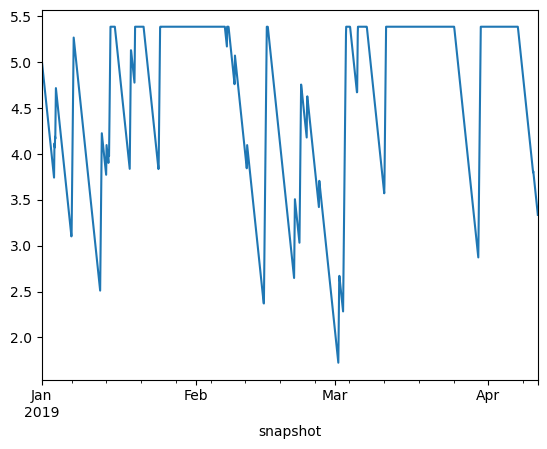

In [333]:
# Inspect the electrolysis input power
#n.links_t.p0["electrolyser"][:24*100].plot()

# Inspect the methanol synthesis input power
n.links_t.p0["methanol_synthesis"][:24*100].plot()

<Axes: xlabel='snapshot'>

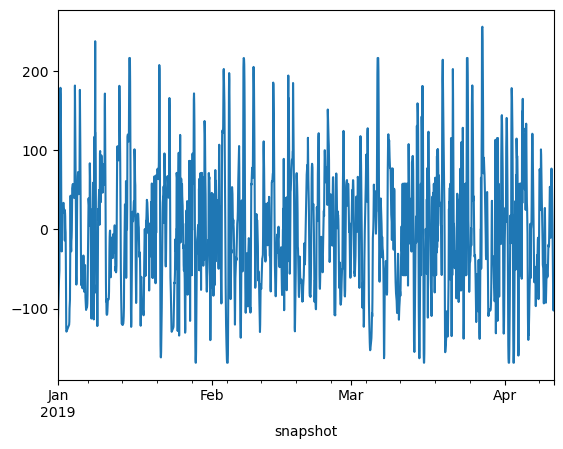

In [334]:
# Inspect the charging flow
n.links_t.p0["hydrogen_flow"][:24*100].plot()

<Axes: xlabel='snapshot'>

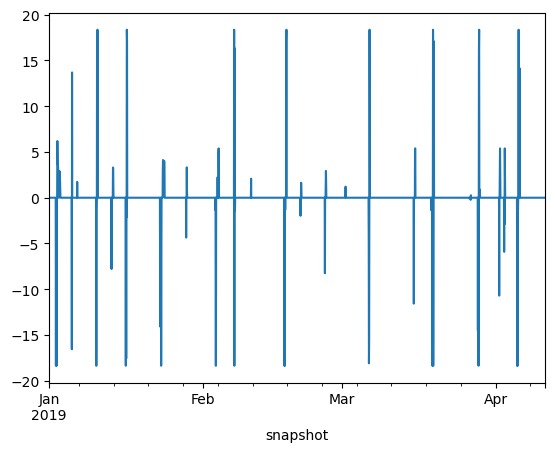

In [335]:
# Inspect the charging flow
n.storage_units_t.p["battery"][:24*100].plot()

<Axes: xlabel='snapshot'>

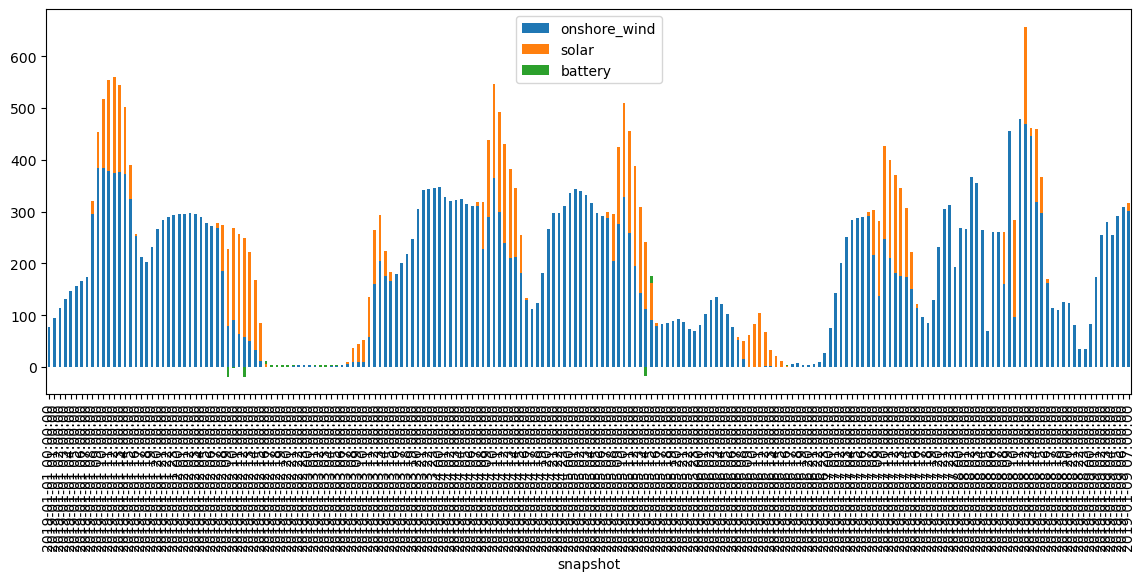

In [336]:
# Inspect storage interaction with other powerplants to supply loads
load = n.loads_t.p
pow_gen = n.generators_t.p
storage = n.storage_units_t.p
result = pd.concat([pow_gen, storage, load], axis=1)

plot = result.loc[
    :, ~result.columns.isin(["methanol_load"])
]  # drop load and nuclear columns
plot.iloc[:200, :].plot(kind="bar", stacked=True, figsize=(14, 5))

In [337]:
n.statistics()

Optimal Capacity  Installed Capacity  \
Generator   solar                      244.37337                 0.0   
            wind                       516.86138                 0.0   
Link        Electrolyser               652.45642                 0.0   
            hydrogen                   256.13301                 0.0   
            methanol                    88.57275                 0.0   
            methanol_synthesis           5.38695                 0.0   
Load        -                            0.00000                 0.0   
StorageUnit -                           18.35500                 0.0   
Store       hydrogen                  2430.81130                 0.0   
            methanol                 73577.38700                 0.0   

                                      Supply    Withdrawal  Energy Balance  \
Generator   solar               3.822692e+05  0.000000e+00    3.822692e+05   
            wind                1.508780e+06  0.000000e+00    1.508780e+06   
Link        Electrolyser        1.095000e+06  1.855932e+06   -7.609322e+05   
            hydrogen            4.843602e+05  4.843602e+05    0.000000e+00   
            methanol            2.308988e+05  2.308988e+05    0.000000e+00   
            methanol_synthesis  8.760000e+05  1.130040e+06   -2.540400e+05   
Load        -                   0.000000e+00  8.760000e+05   -8.760000e+05   
StorageUnit -                   1.036212e+03  1.112741e+03   -7.652876e+01   
Store       hydrogen            2.421801e+05  2.421801e+05    2.000000e-05   
            methanol            1.154494e+05  1.154494e+05   -1.060000e-03   

                                Transmission  Capacity Factor   Curtailment  \
Generator   solar                    0.00000         0.178571   23636.93876   
            wind                     0.00000         0.333233  108294.65959   
Link        Electrolyser             0.00000         0.324718       0.00000   
            hydrogen                -0.00002         0.215873       0.00000   
            methanol                 0.00106         0.297589       0.00000   
            methanol_synthesis       0.00000         0.742535       0.00000   
Load        -                        0.00000              NaN       0.00000   
StorageUnit -                        0.00000         0.013365  160866.31124   
Store       hydrogen                 0.00000         0.350714       0.00000   
            methanol                 0.00000         0.335643       0.00000   

                                Capital Expenditure  Operational Expenditure  \
Generator   solar                      1.037367e+07             0.000000e+00   
            wind                       2.835320e+07             0.000000e+00   
Link        Electrolyser               3.205929e+04             0.000000e+00   
            hydrogen                   0.000000e+00            -2.000000e-05   
            methanol                   0.000000e+00             1.060000e-03   
            methanol_synthesis         1.556493e+07             6.534960e+06   
Load        -                          0.000000e+00             0.000000e+00   
StorageUnit -                          3.385317e+05             0.000000e+00   
Store       hydrogen                   1.232759e+07             2.000000e-05   
            methanol                   7.090302e+05            -1.060000e-03   

                                     Revenue  Market Value  
Generator   solar               1.037367e+07     27.137078  
            wind                2.835320e+07     18.792145  
Link        Electrolyser        3.205961e+04      0.029278  
            hydrogen           -2.000000e-05           NaN  
            methanol            1.060000e-03           NaN  
            methanol_synthesis  2.209989e+07     25.228188  
Load        -                  -7.423397e+07           NaN  
StorageUnit -                   3.385317e+05    326.698537  
Store       hydrogen            1.232759e+07     50.902569  
            methano

In [340]:
# Extract statistics
stats_df = n.statistics()
#stats_df.to_csv("/Users/philip/Desktop/AGORA/China PyPSA LCOX/ code/data/LCOM.csv", index=False)
print(stats_df.index)  # Shows index labels

# Initialize a dictionary to store results
results = {}

# Sum total CAPEX
total_capex = stats_df["Capital Expenditure"].sum()
results["Total CAPEX"] = total_capex

# Sum total OPEX
total_opex = stats_df["Operational Expenditure"].sum()
results["Total OPEX"] = total_opex

# Methanol output
value = stats_df.loc[("Link", "methanol_synthesis"), "Supply"]
MW_to_t_conversion = (1 / 6.2)
m_output = value  # Adjusted as needed
results["Total Methanol Output"] = m_output

# Levelized Cost of Methanol (LCOM)
LCOM = ((total_capex + total_opex) / m_output) / MW_to_t_conversion
results["Total LCOM (USD/t)"] = LCOM

# Convert dictionary to DataFrame
df_results = pd.DataFrame(list(results.items()), columns=["Description", "Value"])

# Define the CSV file path
csv_file_path = "/Users/philip/Desktop/AGORA/China PyPSA LCOX/ code/data/LiNi_Chaoyang_LCOM_2.csv"

# Open file and write both DataFrames in a structured way
with open(csv_file_path, "w", encoding="utf-8-sig") as f:
    f.write("### Statistics Data ###\n")
    stats_df.to_csv(f, index=True)
    
    f.write("\n### Results Summary ###\n")
    df_results.to_csv(f, index=False)

# Provide file path for download
csv_file_path

MultiIndex([(  'Generator',              'solar'),
            (  'Generator',               'wind'),
            (       'Link',       'Electrolyser'),
            (       'Link',           'hydrogen'),
            (       'Link',           'methanol'),
            (       'Link', 'methanol_synthesis'),
            (       'Load',                  '-'),
            ('StorageUnit',                  '-'),
            (      'Store',           'hydrogen'),
            (      'Store',           'methanol')],
           )


'/Users/philip/Desktop/AGORA/China PyPSA LCOX/ code/data/LiNi_Chaoyang_LCOM_2.csv'

In [339]:
# Exporting Methanol network
n.export_to_netcdf("/Users/philip/Desktop/AGORA/China PyPSA LCOX/2024-10-PyPSA-H2-Training/results/methanol-1.nc")

INFO:pypsa.io:Exported network 'methanol-1.nc' contains: storage_units, buses, loads, links, stores, generators


<xarray.Dataset> Size: 3MB
Dimensions:                            (snapshots: 8760, investment_periods: 0,
                                        storage_units_i: 1,
                                        storage_units_t_p_i: 1,
                                        storage_units_t_p_dispatch_i: 1,
                                        storage_units_t_p_store_i: 1,
                                        storage_units_t_state_of_charge_i: 1,
                                        ...
                                        links_t_p0_i: 4, links_t_p1_i: 4,
                                        links_t_p2_i: 1, stores_i: 2,
                                        stores_t_p_i: 2, stores_t_e_i: 2,
                                        generators_i: 2,
                                        generators_t_p_max_pu_i: 2,
                                        generators_t_p_i: 2)
Coordinates: (12/22)
  * snapshots                          (snapshots) int64 70kB 0 1 ... 8758 8759
  * investment_periods                 (investment_periods) int64 0B 
  * storage_units_i                    (storage_units_i) object 8B 'battery'
  * storage_units_t_p_i                (storage_units_t_p_i) object 8B 'battery'
  * storage_units_t_p_dispatch_i       (storage_units_t_p_dispatch_i) object 8B ...
  * storage_units_t_p_store_i          (storage_units_t_p_store_i) object 8B ...
    ...                                 ...
  * stores_i                           (stores_i) object 16B 'hydrogen_tank' ...
  * stores_t_p_i                       (stores_t_p_i) object 16B 'hydrogen_ta...
  * stores_t_e_i                       (stores_t_e_i) object 16B 'hydrogen_ta...
  * generators_i                       (generators_i) object 16B 'onshore_win...
  * generators_t_p_max_pu_i            (generators_t_p_max_pu_i) object 16B '...
  * generators_t_p_i                   (generators_t_p_i) object 16B 'onshore...
Data variables: (12/62)
    snapshots_snapshot                 (snapshots) datetime64[ns] 70kB 2019-0...
    snapshots_objective                (snapshots) float64 70kB 1.0 1.0 ... 1.0
    snapshots_stores                   (snapshots) float64 70kB 1.0 1.0 ... 1.0
    snapshots_generators               (snapshots) float64 70kB 1.0 1.0 ... 1.0
    investment_periods_objective       (investment_periods) object 0B 
    investment_periods_years           (investment_periods) object 0B 
    ...                                 ...
    generators_carrier                 (generators_i) object 16B 'wind' 'solar'
    generators_lifetime                (generators_i) float64 16B 20.0 25.0
    generators_capital_cost            (generators_i) float64 16B 5.486e+04 4...
    generators_p_nom_opt               (generators_i) float64 16B 516.9 244.4
    generators_t_p_max_pu              (snapshots, generators_t_p_max_pu_i) float64 140kB ...
    generators_t_p                     (snapshots, generators_t_p_i) float64 140kB ...
Attributes:
    network__linearized_uc:      0
    network__multi_invest:       0
    network_name:                
    network_objective:           74233976.01878351
    network_objective_constant:  0.0
    network_pypsa_version:       0.32.1
    network_srid:                4326
    crs:                         {"_crs": "GEOGCRS[\"WGS 84\",ENSEMBLE[\"Worl...
    meta:                        {}

In [130]:
"""
# notes
1. update numbers
1.1. update solar #check
1.2. update on_wind #check
1.3. update electrolyser #check (not sure if satisfactory, ramp up?)
1.4. update methanol_synthesis #check (not sure if satisfactory, ramp up?)
1.5. update hydrogen storage #check
1.6. update methanol tank ? 
1.7. update battery storage #check (better data available?) 

2. create new wind and solar profiles for China #check
2.1 ninja for wind #check
2.2 solar atlas for solar #check using 40 degree tilt

# questions: 
1. Should there be a curtailment option for solar and wind, or an option to sell excess power to the power market? 
1.1 I am raising this question, as the electrolysis is primarily only running when solar energy is available, instead of more constantly, which seams the intuitive way, given that RES is so cheap?
2. both electrolyser and methanol_synthesis currently behave according to the intermittance of wind (and solar but less so) 
3. The battery seems to not connect, something seems wrong here. I do wonder if the unit for the capex shouldnt be MWh and not MW? 
4. How do I now determine the LCOA of the whole model? I haven't quite understood how that works.
"""

"\n# notes\n1. update numbers\n1.1. update solar #check\n1.2. update on_wind #check\n1.3. update electrolyser #check (not sure if satisfactory, ramp up?)\n1.4. update methanol_synthesis #check (not sure if satisfactory, ramp up?)\n1.5. update hydrogen storage #check\n1.6. update methanol tank ? \n1.7. update battery storage #check (better data available?) \n\n2. create new wind and solar profiles for China #check\n2.1 ninja for wind #check\n2.2 solar atlas for solar #check using 40 degree tilt\n\n# questions: \n1. Should there be a curtailment option for solar and wind, or an option to sell excess power to the power market? \n1.1 I am raising this question, as the electrolysis is primarily only running when solar energy is available, instead of more constantly, which seams the intuitive way, given that RES is so cheap?\n2. both electrolyser and methanol_synthesis currently behave according to the intermittance of wind (and solar but less so) \n3. The battery seems to not connect, somet

In [131]:
#References: 
#1- Agora Energiewende (2024). PyPSA Agora H2 Training. https://github.com/agoenergy/pypsa-agora-h2-training/tree/main
#2- Agora Energy Transition China (2025). China green LCO-X dataset. 
#3- wind and solar profiles: https://www.renewables.ninja/
#4 - Bodke, N., Pedersen, T. Andresen, G. (2021). Optimal Scheduling of Flexible Power-to-X Technologies in the Day-ahead Electricity Market. https://arxiv.org/pdf/2110.09800 